In [1]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
from datetime import datetime
import os
import shutil
import argparse
import time
import json
import cc3d
from collections import defaultdict
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
import torchio as tio
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from utils import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets
%autoreload 2

In [42]:
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace

# from https://github.com/blufzzz/learnable-triangulation-pytorch/blob/master/mvn/models/v2v.py

class Basic3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(Basic3DBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1, padding=((kernel_size-1)//2)),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Res3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Res3DBlock, self).__init__()
        self.res_branch = nn.Sequential(
            nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True),
            nn.Conv3d(out_planes, out_planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_planes)
        )

        if in_planes == out_planes:
            self.skip_con = nn.Sequential()
        else:
            self.skip_con = nn.Sequential(
                nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm3d(out_planes)
            )

    def forward(self, x):
        res = self.res_branch(x)
        skip = self.skip_con(x)
        return F.relu(res + skip, True)


class Pool3DBlock(nn.Module):
    def __init__(self, pool_size):
        super(Pool3DBlock, self).__init__()
        self.pool_size = pool_size

    def forward(self, x):
        return F.max_pool3d(x, kernel_size=self.pool_size, stride=self.pool_size)


class Upsample3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride):
        super(Upsample3DBlock, self).__init__()
        assert(kernel_size == 2)
        assert(stride == 2)
        self.block = nn.Sequential(
            nn.ConvTranspose3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=0, output_padding=0),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class EncoderDecorder(nn.Module):
    def __init__(self, max_channel=128):
        super().__init__()

        self.encoder_pool1 = Pool3DBlock(2)
        self.encoder_res1 = Res3DBlock(32, max_channel//2)
        self.encoder_pool2 = Pool3DBlock(2)
        self.encoder_res2 = Res3DBlock(max_channel//2, max_channel)
        self.encoder_pool3 = Pool3DBlock(2)
        self.encoder_res3 = Res3DBlock(max_channel, max_channel)
        self.encoder_pool4 = Pool3DBlock(2)
        self.encoder_res4 = Res3DBlock(max_channel, max_channel)
        self.encoder_pool5 = Pool3DBlock(2)
        self.encoder_res5 = Res3DBlock(max_channel, max_channel)

        self.mid_res = Res3DBlock(max_channel, max_channel)

        self.decoder_res5 = Res3DBlock(max_channel, max_channel)
        self.decoder_upsample5 = Upsample3DBlock(max_channel, max_channel, 2, 2)
        self.decoder_res4 = Res3DBlock(max_channel, max_channel)
        self.decoder_upsample4 = Upsample3DBlock(max_channel, max_channel, 2, 2)
        self.decoder_res3 = Res3DBlock(max_channel, max_channel)
        self.decoder_upsample3 = Upsample3DBlock(max_channel, max_channel, 2, 2)
        self.decoder_res2 = Res3DBlock(max_channel, max_channel)
        self.decoder_upsample2 = Upsample3DBlock(max_channel, max_channel//2, 2, 2)
        self.decoder_res1 = Res3DBlock(max_channel//2, max_channel//2)
        self.decoder_upsample1 = Upsample3DBlock(max_channel//2, 32, 2, 2)

        self.skip_res1 = Res3DBlock(32, 32)
        self.skip_res2 = Res3DBlock(max_channel//2, max_channel//2)
        self.skip_res3 = Res3DBlock(max_channel, max_channel)
        self.skip_res4 = Res3DBlock(max_channel, max_channel)
        self.skip_res5 = Res3DBlock(max_channel, max_channel)

    def forward(self, x):
        skip_x1 = self.skip_res1(x)
        x = self.encoder_pool1(x)
        x = self.encoder_res1(x)
        skip_x2 = self.skip_res2(x)
        x = self.encoder_pool2(x)
        x = self.encoder_res2(x)
        skip_x3 = self.skip_res3(x)
        x = self.encoder_pool3(x)
        x = self.encoder_res3(x)
        skip_x4 = self.skip_res4(x)
        x = self.encoder_pool4(x)
        x = self.encoder_res4(x)
        skip_x5 = self.skip_res5(x)
        x = self.encoder_pool5(x)
        x = self.encoder_res5(x)

        x = self.mid_res(x)

        x = self.decoder_res5(x)
        x = self.decoder_upsample5(x)
        x = x + skip_x5 
        x = self.decoder_res4(x)
        x = self.decoder_upsample4(x)
        x = x + skip_x4
        x = self.decoder_res3(x)
        x = self.decoder_upsample3(x)
        x = x + skip_x3
        x = self.decoder_res2(x)
        x = self.decoder_upsample2(x)
        x = x + skip_x2
        x = self.decoder_res1(x)
        x = self.decoder_upsample1(x)
        x = x + skip_x1

        return x


class V2VModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        input_channels = 4#config.model.input_channels
        output_channels = 1#config.model.output_channels
        max_channel = config.model.max_channel_encoder_decoder

        self.front_layers = nn.Sequential(
            Basic3DBlock(input_channels, 16, 7),
            Res3DBlock(16, 32),
            Res3DBlock(32, 32),
            Res3DBlock(32, 32)
        )

        self.encoder_decoder = EncoderDecorder(max_channel)

        self.back_layers = nn.Sequential(
            Res3DBlock(32, 32),
            Basic3DBlock(32, 32, 1),
            Basic3DBlock(32, 32, 1),
        )

        self.output_layer = nn.Conv3d(32, output_channels, kernel_size=1, stride=1, padding=0)

        self._initialize_weights()

    def forward(self, x):
        x = self.front_layers(x)
        x = self.encoder_decoder(x)
        x = self.back_layers(x)
        x = self.output_layer(x)

        x = F.softmax(x, dim=1)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_normal_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.001)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_normal_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.001)
                nn.init.constant_(m.bias, 0)

In [43]:
# class Foo(Dataset):

#     def __init__(self):
#         self.iterator = np.arange(10)
#     def __getitem__(self, i):
#         return self.iterator[i]
#     def __len__(self):
#         return len(self.iterator)

In [44]:
# foo = DataLoader(Foo(), batch_size = 2, shuffle=True)
# for b in foo:
#     print(b)

In [45]:
# foo = DataLoader(Foo(), batch_size = 2, shuffle=True)
# for b in foo:
#     print(b)

In [46]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 3
plt.rcParams['font.size'] = 20

In [47]:
logdir = 'logs_seg/v2v_whole_s128_bs1_GN_trim_DICE_TSC_AUG@07.12.2021-00:48:11/'
# logdir = 'logs/v2v_whole_s128_bs1_GN_trim_DICE_AUG@05.12.2021-18:14:53'
# logdir = 'logs/v2v_whole_s128_bs1_GN_DICE_AUG_ALL_lr1e-3@20.01.2022-00:52:08'
# logdir='logs_seg/v2v128_whole_s128_bs1_GN_DICE_AUG_ALL_lr1e-3@20.01.2022-16:19:36'

# Load model, setup dataloaders

In [48]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [49]:
config.dataset.root = '/media/tom/ibulygin/fcd_data/normalized_tensors/'
config.dataset.metadata_path = 'metadata.npy'

In [50]:
device = torch.device('cuda:1')

writer = None
model = V2VModel(config).to(device)
print('Model created!')

# setting datasets
train_dataset, val_dataset = create_datasets(config)
train_dataloader = DataLoader(train_dataset, batch_size=config.opt.train_batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config.opt.val_batch_size, shuffle=False)

# setting model stuff
criterion = {
    "CE": torch.nn.CrossEntropyLoss(),
    "BCE": torch.nn.BCELoss(),
    "Dice": None
}[config.opt.criterion]

model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights.pth'))
print('LOADING from epoch:',model_dict['epoch'])
print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))
model.load_state_dict(model_dict['model_state'])

Model created!
LOADING from epoch: 69
val dataloder len:  8 train dataloder len:  69


RuntimeError: Error(s) in loading state_dict for V2VModel:
	Missing key(s) in state_dict: "front_layers.0.weight", "front_layers.0.bias", "front_layers.0.running_mean", "front_layers.0.running_var", "front_layers.1.block.0.weight", "front_layers.1.block.0.bias", "front_layers.1.block.1.weight", "front_layers.1.block.1.bias", "front_layers.1.block.1.running_mean", "front_layers.1.block.1.running_var", "front_layers.2.res_branch.1.running_mean", "front_layers.2.res_branch.1.running_var", "front_layers.2.res_branch.4.running_mean", "front_layers.2.res_branch.4.running_var", "front_layers.2.skip_con.0.weight", "front_layers.2.skip_con.0.bias", "front_layers.2.skip_con.1.weight", "front_layers.2.skip_con.1.bias", "front_layers.2.skip_con.1.running_mean", "front_layers.2.skip_con.1.running_var", "front_layers.3.res_branch.1.running_mean", "front_layers.3.res_branch.1.running_var", "front_layers.3.res_branch.4.running_mean", "front_layers.3.res_branch.4.running_var", "front_layers.4.res_branch.0.weight", "front_layers.4.res_branch.0.bias", "front_layers.4.res_branch.1.weight", "front_layers.4.res_branch.1.bias", "front_layers.4.res_branch.1.running_mean", "front_layers.4.res_branch.1.running_var", "front_layers.4.res_branch.3.weight", "front_layers.4.res_branch.3.bias", "front_layers.4.res_branch.4.weight", "front_layers.4.res_branch.4.bias", "front_layers.4.res_branch.4.running_mean", "front_layers.4.res_branch.4.running_var", "encoder_decoder.encoder_res1.res_branch.1.running_mean", "encoder_decoder.encoder_res1.res_branch.1.running_var", "encoder_decoder.encoder_res1.res_branch.4.running_mean", "encoder_decoder.encoder_res1.res_branch.4.running_var", "encoder_decoder.encoder_res1.skip_con.1.running_mean", "encoder_decoder.encoder_res1.skip_con.1.running_var", "encoder_decoder.encoder_res2.res_branch.1.running_mean", "encoder_decoder.encoder_res2.res_branch.1.running_var", "encoder_decoder.encoder_res2.res_branch.4.running_mean", "encoder_decoder.encoder_res2.res_branch.4.running_var", "encoder_decoder.encoder_res2.skip_con.1.running_mean", "encoder_decoder.encoder_res2.skip_con.1.running_var", "encoder_decoder.encoder_res3.res_branch.1.running_mean", "encoder_decoder.encoder_res3.res_branch.1.running_var", "encoder_decoder.encoder_res3.res_branch.4.running_mean", "encoder_decoder.encoder_res3.res_branch.4.running_var", "encoder_decoder.encoder_res4.res_branch.1.running_mean", "encoder_decoder.encoder_res4.res_branch.1.running_var", "encoder_decoder.encoder_res4.res_branch.4.running_mean", "encoder_decoder.encoder_res4.res_branch.4.running_var", "encoder_decoder.encoder_res5.res_branch.1.running_mean", "encoder_decoder.encoder_res5.res_branch.1.running_var", "encoder_decoder.encoder_res5.res_branch.4.running_mean", "encoder_decoder.encoder_res5.res_branch.4.running_var", "encoder_decoder.mid_res.res_branch.1.running_mean", "encoder_decoder.mid_res.res_branch.1.running_var", "encoder_decoder.mid_res.res_branch.4.running_mean", "encoder_decoder.mid_res.res_branch.4.running_var", "encoder_decoder.decoder_res5.res_branch.1.running_mean", "encoder_decoder.decoder_res5.res_branch.1.running_var", "encoder_decoder.decoder_res5.res_branch.4.running_mean", "encoder_decoder.decoder_res5.res_branch.4.running_var", "encoder_decoder.decoder_upsample5.block.1.running_mean", "encoder_decoder.decoder_upsample5.block.1.running_var", "encoder_decoder.decoder_res4.res_branch.1.running_mean", "encoder_decoder.decoder_res4.res_branch.1.running_var", "encoder_decoder.decoder_res4.res_branch.4.running_mean", "encoder_decoder.decoder_res4.res_branch.4.running_var", "encoder_decoder.decoder_upsample4.block.1.running_mean", "encoder_decoder.decoder_upsample4.block.1.running_var", "encoder_decoder.decoder_res3.res_branch.1.running_mean", "encoder_decoder.decoder_res3.res_branch.1.running_var", "encoder_decoder.decoder_res3.res_branch.4.running_mean", "encoder_decoder.decoder_res3.res_branch.4.running_var", "encoder_decoder.decoder_upsample3.block.1.running_mean", "encoder_decoder.decoder_upsample3.block.1.running_var", "encoder_decoder.decoder_res2.res_branch.1.running_mean", "encoder_decoder.decoder_res2.res_branch.1.running_var", "encoder_decoder.decoder_res2.res_branch.4.running_mean", "encoder_decoder.decoder_res2.res_branch.4.running_var", "encoder_decoder.decoder_upsample2.block.1.running_mean", "encoder_decoder.decoder_upsample2.block.1.running_var", "encoder_decoder.decoder_res1.res_branch.1.running_mean", "encoder_decoder.decoder_res1.res_branch.1.running_var", "encoder_decoder.decoder_res1.res_branch.4.running_mean", "encoder_decoder.decoder_res1.res_branch.4.running_var", "encoder_decoder.decoder_upsample1.block.1.running_mean", "encoder_decoder.decoder_upsample1.block.1.running_var", "encoder_decoder.skip_res1.res_branch.1.running_mean", "encoder_decoder.skip_res1.res_branch.1.running_var", "encoder_decoder.skip_res1.res_branch.4.running_mean", "encoder_decoder.skip_res1.res_branch.4.running_var", "encoder_decoder.skip_res2.res_branch.1.running_mean", "encoder_decoder.skip_res2.res_branch.1.running_var", "encoder_decoder.skip_res2.res_branch.4.running_mean", "encoder_decoder.skip_res2.res_branch.4.running_var", "encoder_decoder.skip_res3.res_branch.1.running_mean", "encoder_decoder.skip_res3.res_branch.1.running_var", "encoder_decoder.skip_res3.res_branch.4.running_mean", "encoder_decoder.skip_res3.res_branch.4.running_var", "encoder_decoder.skip_res4.res_branch.1.running_mean", "encoder_decoder.skip_res4.res_branch.1.running_var", "encoder_decoder.skip_res4.res_branch.4.running_mean", "encoder_decoder.skip_res4.res_branch.4.running_var", "encoder_decoder.skip_res5.res_branch.1.running_mean", "encoder_decoder.skip_res5.res_branch.1.running_var", "encoder_decoder.skip_res5.res_branch.4.running_mean", "encoder_decoder.skip_res5.res_branch.4.running_var", "back_layers.0.res_branch.1.running_mean", "back_layers.0.res_branch.1.running_var", "back_layers.0.res_branch.4.running_mean", "back_layers.0.res_branch.4.running_var", "back_layers.1.block.1.running_mean", "back_layers.1.block.1.running_var", "back_layers.2.block.1.running_mean", "back_layers.2.block.1.running_var". 
	Unexpected key(s) in state_dict: "front_layers.0.block.0.weight", "front_layers.0.block.0.bias", "front_layers.0.block.1.weight", "front_layers.0.block.1.bias", "front_layers.1.res_branch.0.weight", "front_layers.1.res_branch.0.bias", "front_layers.1.res_branch.1.weight", "front_layers.1.res_branch.1.bias", "front_layers.1.res_branch.3.weight", "front_layers.1.res_branch.3.bias", "front_layers.1.res_branch.4.weight", "front_layers.1.res_branch.4.bias", "front_layers.1.skip_con.0.weight", "front_layers.1.skip_con.0.bias", "front_layers.1.skip_con.1.weight", "front_layers.1.skip_con.1.bias". 
	size mismatch for front_layers.2.res_branch.0.weight: copying a param with shape torch.Size([32, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3, 3]).

In [51]:
len(val_dataloader)

8

In [52]:
get_capacity(model)

1.02

# Forward pass

In [31]:
brains = []
labels = []
predicted_labels = []
dices = []
coverages=[]

iterator = enumerate(val_dataloader)
with torch.no_grad():
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):

        assert brain_tensor.shape[0] == 1

        # prepare
        if config.interpolate:
            brain_tensor = F.interpolate(brain_tensor.type(torch.float), config.interpolation_size).to(device)
            label_tensor = F.interpolate(label_tensor.type(torch.float), config.interpolation_size).to(device) # unsqueeze channel
            mask_tensor = F.interpolate(mask_tensor.type(torch.float), config.interpolation_size).to(device) # unsqueeze channel
        else:
            brain_tensor = brain_tensor.to(device)
            label_tensor = label_tensor.to(device)
            mask_tensor = mask_tensor.to(device)

        # forward pass
        label_tensor_predicted = model(brain_tensor) # [bs,1,ps,ps,ps]
        label_tensor_predicted = label_tensor_predicted*mask_tensor

        dice_score = DiceScoreBinary(label_tensor_predicted.detach().cpu(), label_tensor.detach().cpu())
        coverage = (label_tensor_predicted.detach().cpu()*label_tensor.detach().cpu()).sum() / label_tensor.detach().cpu().sum()

        dices.append(dice_score.item())
        coverages.append(coverage.item())

        brain_tensor_sample = brain_tensor.detach().cpu().numpy()[0] # [C,H,W,D]
        label_tensor_sample = label_tensor.detach().cpu().numpy()[0,0] # [H,W,D] 
        label_tensor_predicted_sample = label_tensor_predicted.detach().cpu().numpy()[0,0] # [H,W,D]

        # crucial for freein CUDA memory
        del label_tensor_predicted, brain_tensor, label_tensor, mask_tensor

        brains.append(brain_tensor_sample)
        labels.append(label_tensor_sample)
        predicted_labels.append(label_tensor_predicted_sample)

0it [00:00, ?it/s]


RuntimeError: Given groups=1, weight of size [16, 10, 7, 7, 7], expected input[1, 4, 128, 128, 128] to have 10 channels, but got 4 channels instead

In [10]:
# for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(enumerate(val_dataloader)):
    
#     if iter_i < 1:
#         continue
    
#     assert brain_tensor.shape[0] == 1
    
#     # prepare
#     if config.interpolate:
#         brain_tensor = F.interpolate(brain_tensor, config.interpolation_size).to(device)
#         label_tensor = F.interpolate(label_tensor, config.interpolation_size).to(device) # unsqueeze channel
#         mask_tensor = F.interpolate(mask_tensor, config.interpolation_size).to(device) # unsqueeze channel
#     else:
#         brain_tensor = brain_tensor.to(device)
#         label_tensor = label_tensor.to(device)
#         mask_tensor = mask_tensor.to(device)

#     # forward pass
#     label_tensor_predicted = model(brain_tensor) # [bs,1,ps,ps,ps]
#     label_tensor_predicted = label_tensor_predicted*mask_tensor
    
#     dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
    
#     print(dice_score)

In [11]:
# for brain in brains:
#     N = len(brain)
#     fig, ax = plt.subplots(1,N, sharex=True, sharey=True)
#     X_max, Y_max, Z_max = brain[0].shape
#     for i,ax in enumerate(ax):
#         brain_slice = brain[i][:,Y_max//2,:]
#         ax.imshow(brain_slice)
#     plt.show()

In [12]:
coverages

[0.004367941990494728,
 0.004287193529307842,
 0.004106511827558279,
 0.003701212350279093,
 0.002620510058477521,
 0.0038791990373283625,
 0.0030463605653494596]

In [13]:
dices

[0.003112341044470668,
 0.0031131398864090443,
 0.005603819619864225,
 0.0038454721216112375,
 0.0006429022760130465,
 0.0060189287178218365,
 0.0011410253355279565]

In [14]:
np.mean(dices)

0.0033539470002454308

Hard examples:



In [6]:
# train_labels = train_dataloader.dataset.labels
# train_dices = dict(zip(train_labels, dices))
# np.save(os.path.join(logdir, 'train_dices'), train_dices)

In [7]:
# dices_tsc = dices

In [8]:
# plt.figure(figsize=(25,5))
# plt.bar(train_labels, dices_ng, alpha=0.5, label='No geom')
# plt.bar(train_labels, dices_tsc, alpha=0.5, label='with TSC')
# exp_name = logdir.split('/')[1]
# plt.title(f'Training')
# plt.ylabel('Dice score')
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()

In [15]:
val_labels = val_dataloader.dataset.labels
# val_dices = dict(zip(val_labels, dices))
# np.save(os.path.join(logdir, 'val_dices'), val_dices)

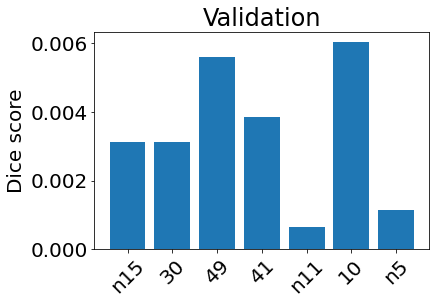

In [16]:
plt.ion()
plt.figure()
plt.bar(val_labels, dices)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

In [13]:
# plt.bar(val_labels, dices, alpha=0.5, label='No geom')
# plt.bar(val_labels, dices_tsc, alpha=0.5, label='with TSC')

# exp_name = logdir.split('/')[1]
# plt.title(f'Validation')
# plt.ylabel('Dice score')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

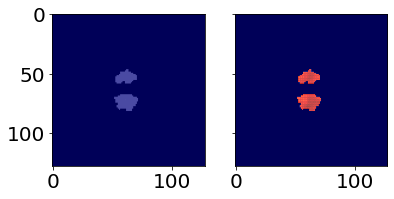

In [18]:
ind = np.argmax(dices)
plt.ioff()
camera = video_comparison([brains[ind][9], brains[ind][9]], 
                          [labels[ind], predicted_labels[ind]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Use CRF

In [142]:
ind = np.argmax(dices)

label = predicted_masks[ind]
brain = brain_tensors[ind]
label_gt = real_masks[ind]
dice = dices[ind]

In [143]:
def to_tensor(array):
    return torch.tensor(np.expand_dims(array, axis=(0,1)))

In [144]:
DiceScoreBinary(to_tensor(label), 
                to_tensor(label_gt))

tensor(0.3648)

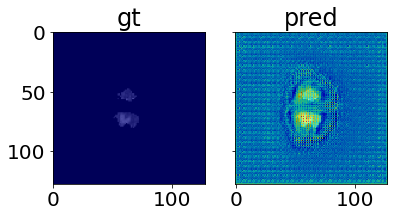

In [148]:
plt.ioff()

camera = video_comparison([brain,brain],
                             [label_gt, label],
                             titles=['gt','pred'])
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [149]:
# plt.ioff()
# camera = video(brain,
#                label, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
plt.ioff()
camera = compare(brain,label_gt, 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [37]:
import denseCRF3D

def densecrf3d(I, P, param):
    """
    input parameters:
        I: a numpy array of shape [D, H, W, C], where C is the channel number
           type of I should be np.uint8, and the values are in [0, 255]
        P: a probability map of shape [D, H, W, L], where L is the number of classes
           type of P should be np.float32
        param: a tuple giving parameters of CRF. see the following two examples for details.
    """
    return denseCRF3D.densecrf3d(I, P, param)


dense_crf_param = {}
dense_crf_param['MaxIterations'] = 1.0 #
dense_crf_param['PosW'] = 2.0 #
dense_crf_param['PosRStd'] = 1
dense_crf_param['PosCStd'] = 1
dense_crf_param['PosZStd'] = 1
dense_crf_param['BilateralW'] = 1.0
dense_crf_param['BilateralRStd'] = 1.0
dense_crf_param['BilateralCStd'] = 1.0
dense_crf_param['BilateralZStd'] = 1.0
dense_crf_param['ModalityNum'] = 1
dense_crf_param['BilateralModsStds'] = (1.0,)

brain_prep = (np.expand_dims(brain,-1)*255).astype('uint8')
label_prep = np.stack([1.0 - label, label], axis=-1)

label_crf = densecrf3d(brain_prep, label_prep, dense_crf_param)

Using addPairwiseBilateral for 1 Modality
MaxIterations :1
PosRStd       :1
PosCStd       :1
PosZStd       :1
PosW          :2
BilateralRStd :1
BilateralCStd :1
BilateralZStd :1
ModalityNum   :1
BilateralW    :1
BilateralModsStds:(1)


In [38]:
# plt.ioff()
# camera = video(brain,
#                label_crf, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [41]:
label_gt.sum()

218.0

In [40]:
label_crf.sum()

4177

In [39]:
DiceScoreBinary(to_tensor(label_crf), 
                to_tensor(label_gt))

tensor(0.)

# Simple thresholding

In [83]:
label_thresh = label.copy()
thresh = 0.5
label_thresh[label_thresh >= thresh] = 1
label_thresh[label_thresh < thresh] = 0

In [131]:
mask = torch.load(val_dataloader.dataset.paths[ind])['mask']
mask = mask[mask.sum(dim=(1,2)) > 0][:,mask.sum(dim=(0,2)) > 0,:][:,:,mask.sum(dim=(0,1)) > 0]
mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).type(torch.float32),
                    config.interpolation_size).numpy()[0,0] > 0

In [132]:
label.sum() / label_gt.sum()

1.8643723

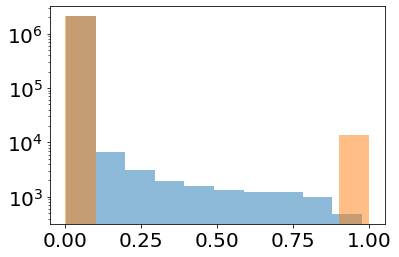

In [133]:
plt.hist(label.flatten(), alpha=0.5)
plt.hist(label_gt.flatten(), alpha=0.5)
plt.yscale('log')
plt.show()

In [134]:
DiceScoreBinary(to_tensor(label_thresh), 
                to_tensor(label_gt))

tensor(0.2977)

(array([7339., 1320.,  843.,  676.,  602.,  578.,  582.,  587.,  625.,
         481.]),
 array([0.00430274, 0.10139041, 0.19847809, 0.29556575, 0.39265344,
        0.48974112, 0.58682877, 0.68391645, 0.78100413, 0.8780918 ,
        0.9751795 ], dtype=float32),
 <BarContainer object of 10 artists>)

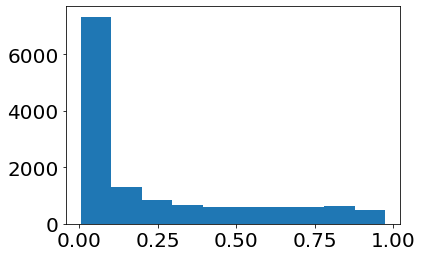

In [135]:
plt.hist(label[label_gt.astype('bool')])

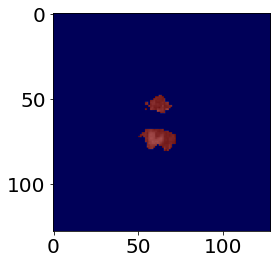

In [136]:
plt.ioff()
camera = video(brain,
               mask, 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [139]:
dice

0.3648377060890198

In [141]:
DiceScoreBinary(to_tensor(label)*mask.astype('int'), 
                to_tensor(label_gt))

tensor(0.3662, dtype=torch.float64)

# Check geom. features concordance

In [53]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

In [22]:
plt.ioff()
camera = video_comparison(brain_tensor_, 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Check augmentation

In [62]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

symmetry = tio.RandomFlip(axes=0)
bias = tio.RandomBiasField(coefficients=0.3)
noise = tio.RandomNoise(std=(0,1e-3))
affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                         degrees=15,
                         translation=(1,1,1),
                         center='image',
                         default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, bias, noise, affine, rescale]) # , affine

subject = tio.Subject(
            t1=tio.ScalarImage(tensor=brain_tensor_),
            diagnosis='positive'
        )

transformed = augmentation(subject)
brain_tensor_transformed = transformed['t1'].tensor.numpy()

In [88]:
# plt.imshow(brain_tensor_transformed[1,:,10,:])
# plt.colorbar()

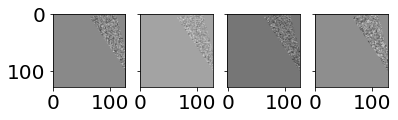

In [75]:
plt.ioff()
camera = video_comparison(brain_tensor_transformed)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation